# W266 Final Project - Amazon Reviews

This notebook is to read in the cleaned data and work with the data in keras.

http://jmcauley.ucsd.edu/data/amazon/links.html

In [1]:
import pandas as pd
import gzip
import random
from collections import defaultdict
import seaborn as sns
import numpy as np
import re

import nltk
from nltk.corpus import stopwords
import string

import tensorflow_hub as hub
import tensorflow as tf

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, Input
from keras.layers.embeddings import Embedding
from keras.layers.merge import concatenate
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

import h5py

import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.models.keyedvectors import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

/home/lance_miles/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
W0404 17:57:49.502410 139842020026176 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14
Using TensorFlow backend.


In [2]:
def loadInitialData(loadDat = True):
    if loadDat == True:
        train_data_name = '../../train_data.pkl'
        train_data = pd.read_pickle(train_data_name)
        test_data_name = '../../test_data.pkl'
        test_data = pd.read_pickle(test_data_name)
        print('Successfully opened pickled data')
        
        return train_data, test_data

    else:
        files = ['reviews_Video_Games.json.gz', 
                 'reviews_Toys_and_Games.json.gz', 
                 'reviews_Sports_and_Outdoors.json.gz', 
                 'reviews_Movies_and_TV.json.gz',
                 'reviews_Kindle_Store.json.gz', 
                 'reviews_Home_and_Kitchen.json.gz',
                 'reviews_Health_and_Personal_Care.json.gz', 
                 'reviews_Electronics.json.gz',
                 'reviews_Clothing_Shoes_and_Jewelry.json.gz',
                 'reviews_Cell_Phones_and_Accessories.json.gz', 
                 'reviews_CDs_and_Vinyl.json.gz',
                 'reviews_Books.json.gz']
        filesNames = ['reviews_Video_Games', 
                      'reviews_Toys_and_Games',
                      'reviews_Sports_and_Outdoors', 
                      'reviews_Movies_and_TV',
                      'reviews_Kindle_Store', 
                      'reviews_Home_and_Kitchen',
                      'reviews_Health_and_Personal_Care', 
                      'reviews_Electronics',
                      'reviews_Clothing_Shoes_and_Jewelry',
                      'reviews_Cell_Phones_and_Accessories', 
                      'reviews_CDs_and_Vinyl',
                      'reviews_Books']

        print('Looks like you dont have the data.. Will pickle it for you for future use.')

        def dataFullSets(original, concatData, name):
            currentData = original
            appendData = pd.read_csv('../Data/%s'%(concatData))
            appendData['Product'] = name
            newDF = pd.concat([currentData,appendData], sort=True)
            return(newDF)

        train_data = pd.read_csv('../Data/%s_train.csv'%(filesNames[0]))
        train_data['Product'] = filesNames[0]
        test_data = pd.read_csv('../Data/%s_test.csv'%(filesNames[0]))
        test_data['Product'] = filesNames[0]

        random.seed(1203)

        for fileName in filesNames[1:]:
            concatName_train = fileName+'_train.csv'
            concatName_test = fileName+'_test.csv'

            train_data = dataFullSets(train_data, concatName_train, fileName).sample(frac=1)
            test_data = dataFullSets(test_data, concatName_test, fileName).sample(frac=1)

            print('Concatenated', fileName)

        print('Finished building train and test datasets.')

        train_data_name = '../../train_data.pkl'
        train_data.to_pickle(train_data_name)
        test_data_name = '../../test_data.pkl'
        test_data.to_pickle(test_data_name)

        print('Finished pickling for future use.')
        
        return train_data, test_data
        
train_data, test_data = loadInitialData(loadDat = True)

Successfully opened pickled data


In [3]:
train_data.head()

,Product,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,sentiment,summary,unixReviewTime
83381,reviews_Electronics,B00AHPSTRY,"[5, 5]",1.0,just received my screen protector. it's going...,"08 14, 2013",A20EOZ5Q2Z8L1S,Vicki B.,0,SENDING IT BACK!,1376438400
7113,reviews_CDs_and_Vinyl,B00005AQ38,"[6, 6]",1.0,"But instead of the orchestra, we are treated t...","12 23, 2001",A16SS8HYJW7IEJ,"Mark Pollock ""educator""",0,Would be nice to hear the orchestra...,1009065600
58166,reviews_Health_and_Personal_Care,B0007P2OO8,"[0, 0]",5.0,Love this shaving soap and it was the best pri...,"01 15, 2013",A16O37AEI0Y3N,Richard Papaleo,1,Col. Conk is Famous,1358208000
35717,reviews_Home_and_Kitchen,B000AA89GW,"[0, 1]",1.0,It is impossible to join the two pieces of the...,"08 28, 2011",A2OV0337VRTSUV,AF,0,Impossible to close tightly... Makes a mess!!!,1314489600
26850,reviews_Electronics,B00529F3JW,"[2, 2]",1.0,There is no suction on this little vacuum clea...,"01 25, 2013",A3I0B7SO7OE7YG,Terry White,0,Mini Vacuum Cleaner,1359072000


In [4]:
test_data.head()

,Product,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,sentiment,summary,unixReviewTime
11262,reviews_Home_and_Kitchen,B007EESTOY,"[0, 0]",5.0,Love this! Hot drinks stay hot for a couple ho...,"06 7, 2014",A1RAD5380383DT,Jennifer Manelis,1,Great insulation!!!,1402099200
16948,reviews_Health_and_Personal_Care,B0063X0K5I,"[1, 1]",1.0,Paid for next day shipping as reviews said thi...,"05 20, 2014",AYOQUNMV9L23E,David Murray,0,Does not ship in a cold pack,1400544000
18599,reviews_Video_Games,B009CL6LA6,"[0, 0]",5.0,I got it for my teenage grandson for Christmas...,"01 30, 2014",A1Y644EFDB8CZ8,"Elaine A. Stone ""Grandma from Oklahoma""",1,Headset,1391040000
6570,reviews_Cell_Phones_and_Accessories,B0042R8ICO,"[1, 1]",5.0,"This protector is good value. It's very clear,...","08 21, 2011",A1QSXZJMDRH5KY,Yancy,1,Great Clear Protector,1313884800
207,reviews_Toys_and_Games,B003F64T1M,"[4, 4]",5.0,I've had this truck for about a week now. Afte...,"07 18, 2013",A9F5P3EMJINOR,R. Moschgat Jr.,1,Maxstone,1374105600


In [5]:
def decontracted(phrase):
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [6]:
#practice sentence
test_sentence = test_data['reviewText'].iloc[19]
test_sentence

'I could not ask for a better vacuum.  We just got this today and it was together within a minute.  Hubby used it on our wood floor and it picked up really well.  Then he did the 3 carpets that we have and they look almost brand new.  The funny thing is that my older cat batted at it and was hissing a little and the younger one ran out of the room as quick as he could.  It does not make a lot of noise and it a very good product to own.'

In [7]:
#prepare reviews to be split by words
#change to lowercase, remove punctuation and numbers
test_data_word_prep = re.sub("[^a-zA-Z']", " ", test_sentence).lower()
test_data_word_prep = re.sub("[\\s]+", " ", test_data_word_prep)
test_data_word_prep = decontracted(test_data_word_prep)
test_data_word_prep

'i could not ask for a better vacuum we just got this today and it was together within a minute hubby used it on our wood floor and it picked up really well then he did the carpets that we have and they look almost brand new the funny thing is that my older cat batted at it and was hissing a little and the younger one ran out of the room as quick as he could it does not make a lot of noise and it a very good product to own '

In [8]:
#list of words after processing
test_data_word_prep.strip().split()

['i',
 'could',
 'not',
 'ask',
 'for',
 'a',
 'better',
 'vacuum',
 'we',
 'just',
 'got',
 'this',
 'today',
 'and',
 'it',
 'was',
 'together',
 'within',
 'a',
 'minute',
 'hubby',
 'used',
 'it',
 'on',
 'our',
 'wood',
 'floor',
 'and',
 'it',
 'picked',
 'up',
 'really',
 'well',
 'then',
 'he',
 'did',
 'the',
 'carpets',
 'that',
 'we',
 'have',
 'and',
 'they',
 'look',
 'almost',
 'brand',
 'new',
 'the',
 'funny',
 'thing',
 'is',
 'that',
 'my',
 'older',
 'cat',
 'batted',
 'at',
 'it',
 'and',
 'was',
 'hissing',
 'a',
 'little',
 'and',
 'the',
 'younger',
 'one',
 'ran',
 'out',
 'of',
 'the',
 'room',
 'as',
 'quick',
 'as',
 'he',
 'could',
 'it',
 'does',
 'not',
 'make',
 'a',
 'lot',
 'of',
 'noise',
 'and',
 'it',
 'a',
 'very',
 'good',
 'product',
 'to',
 'own']

In [9]:
#commenting out imdb data as it has been pickled

#imdb_reviews = pd.read_csv('../Data/imdb_master_file.csv', encoding="ISO-8859-1")

#imdb_reviews['sentiment'] = np.where(imdb_reviews['label']=='pos',1,0)

#imdb_reviews = imdb_reviews.rename(index=str, columns={"review": "reviewText"})

#imdb_test = imdb_reviews.loc[imdb_reviews.type == 'test',]

#imdb_train = imdb_reviews.loc[imdb_reviews.type == 'train',]

#imdb_test.head()

In [10]:
#code to pull in and clean twitter data, commented out because it has been pickled

#twitter_reviews = pd.read_csv("../../twitter_sentiment_cleaned.csv")

#twitter_pos = twitter_reviews.loc[twitter_reviews.sentiment == 1, ['sentiment','reviewText']]
#twitter_pos = twitter_pos.head(30000)

#twitter_neg = twitter_reviews.loc[twitter_reviews.sentiment == 0, ['sentiment','reviewText']]
#twitter_neg = twitter_neg.head(30000)

#twitter_reviews = pd.concat([twitter_pos,twitter_neg], axis=0)
#twitter_reviews.shape

In [11]:
#code to pull in and clean yelp data, commented out because it has been pickled

#yelp_reviews = pd.read_csv("../../yelp_review.csv", nrows=250000)

#yelp_pos = yelp_reviews.loc[yelp_reviews.stars == 5, ['stars', 'text']]
#yelp_pos['sentiment'] = 1
#yelp_pos = yelp_pos.rename(index=str, columns = {'text':'reviewText'})
#yelp_pos = yelp_pos.drop(['stars'], axis=1)

#yelp_neg = yelp_reviews.loc[yelp_reviews.stars == 1, ['stars', 'text']]
#yelp_neg['sentiment'] = 0
#yelp_neg = yelp_neg.rename(index=str, columns = {'text':'reviewText'})
#yelp_neg = yelp_neg.drop(['stars'], axis=1)

#yelp_reviews = pd.concat([yelp_pos.head(30000), yelp_neg.head(30000)], axis=0)
#yelp_reviews.shape

In [12]:
yelp_zhang_train = pd.read_csv('../../yelp_zhang_pol_train.csv')
yelp_zhang_test = pd.read_csv('../../yelp_zhang_pol_test.csv')

In [13]:
max_length = 200

def loadData(loadDat = True, test_data = test_data, train_data = train_data, 
             yelp_zhang_train = yelp_zhang_train, yelp_zhang_test = yelp_zhang_test):

    
    if loadDat == True:
        train_data_name = '../../train_data_cleaned.pkl'
        train_data = pd.read_pickle(train_data_name)
        
        test_data_name = '../../train_data_cleaned.pkl'
        test_data = pd.read_pickle(test_data_name)
        
        play_data_name = '../../play_data_cleaned.pkl'
        play_data = pd.read_pickle(play_data_name)
        
        twitter_reviews_name = '../../twitter_reviews_cleaned.pkl'
        twitter_reviews = pd.read_pickle(twitter_reviews_name)
        
        imdb_test_name = '../../imdb_test_cleaned.pkl'
        imdb_test = pd.read_pickle(imdb_test_name)
        imdb_train_name = '../../imdb_train_cleaned.pkl'
        imdb_train = pd.read_pickle(imdb_train_name)
        
        yelp_reviews_name = '../../yelp_reviews_cleaned.pkl'
        yelp_reviews = pd.read_pickle(yelp_reviews_name)
        
        yelp_zhang_train_name = '../../yelp_zhang_pol_train_cleaned.pkl'
        yelp_zhang_train = pd.read_pickle(yelp_zhang_train_name)
        yelp_zhang_test_name = '../../yelp_zhang_pol_test_cleaned.pkl'
        yelp_zhang_test = pd.read_pickle(yelp_zhang_test_name)
        
        sst_test_name = '../../sst_test.pkl'
        sst_test = pd.read_pickle(sst_test_name)

        amazon_zhang_test_name = '../../amazon_zhang_pol_test_cleaned.pkl'
        amazon_zhang_test = pd.read_pickle(amazon_zhang_test_name)
        
        print('Successfully opened pickled data')
        
        return train_data, test_data, play_data, twitter_reviews, imdb_test, imdb_train, yelp_reviews, yelp_zhang_train, yelp_zhang_test, sst_test, amazon_zhang_test
    
    else:

        play_data = test_data[:10]

        def decontracted(phrase):
            phrase = re.sub(r"won\'t", "will not", phrase)
            phrase = re.sub(r"can\'t", "can not", phrase)
            phrase = re.sub(r"n\'t", " not", phrase)
            phrase = re.sub(r"\'re", " are", phrase)
            phrase = re.sub(r"\'s", " is", phrase)
            phrase = re.sub(r"\'d", " would", phrase)
            phrase = re.sub(r"\'ll", " will", phrase)
            phrase = re.sub(r"\'t", " not", phrase)
            phrase = re.sub(r"\'ve", " have", phrase)
            phrase = re.sub(r"\'m", " am", phrase)
            return phrase

        def prepReview(data):
            data_prep = str(data['reviewText'])
            data_prep = re.sub("[!?]", ".", data_prep)
            data_prep = re.sub("[^a-zA-Z']", " ", data_prep).lower()
            data_prep = re.sub("[\\s]+", " ", data_prep)
            data_prep = decontracted(data_prep)
            return data_prep

        #function to process review text and split into words
        def splitWords(data):
            return prepReview(data).split()[:max_length]

        #function to process review text and split into sentences
        def splitSentences(data):
            interim = prepReview(data).split()
            reviewTrunc = interim[:max_length]
            return ' '.join(reviewTrunc)


        #list of words from review into column
        sentences = play_data.apply(splitWords, axis=1)
        play_data.insert(loc = 11, column = 'sentenceWords', value = sentences)

        sentences = train_data.apply(splitWords, axis=1)
        train_data.insert(loc = 11,column = 'sentenceWords', value = sentences)

        sentences = test_data.apply(splitWords, axis=1)
        test_data.insert(loc = 11,column = 'sentenceWords', value = sentences)

        #IMDB additions
        sentences = imdb_test.apply(splitWords, axis=1)
        imdb_test.insert(loc = 6,column = 'sentenceWords', value = sentences)
        
        sentences = imdb_train.apply(splitWords, axis=1)
        imdb_train.insert(loc = 6,column = 'sentenceWords', value = sentences)
        
        sentences = twitter_reviews.apply(splitWords, axis=1)
        twitter_reviews.insert(loc = 2,column = 'sentenceWords', value = sentences)
        
        sentences = yelp_reviews.apply(splitWords, axis=1)
        yelp_reviews.insert(loc = 2,column = 'sentenceWords', value = sentences)
        
        sentences = yelp_zhang_train.apply(splitWords, axis=1)
        yelp_zhang_train.insert(loc = 2,column = 'sentenceWords', value = sentences)
        
        sentences = yelp_zhang_test.apply(splitWords, axis=1)
        yelp_zhang_test.insert(loc = 2,column = 'sentenceWords', value = sentences)
        
        sentences = sst_test.apply(splitWords, axis=1)
        sst_test.insert(loc = 2,column = 'sentenceWords', value = sentences)
        
        sentences = amazon_zhang_test.apply(splitWords, axis=1)
        amazon_zhang_test.insert(loc = 2,column = 'sentenceWords', value = sentences)
        
        print('Finished working through the words for each sentences\nOn to the sentences..')

        #list of sentences from review into column
        sentences_split = play_data.apply(splitSentences, axis=1)
        play_data.insert(loc = 12, column = 'sentences', value = sentences_split)

        sentences_split = train_data.apply(splitSentences, axis=1)
        train_data.insert(loc = 12,column = 'sentences', value = sentences_split)

        sentences_split = test_data.apply(splitSentences, axis=1)
        test_data.insert(loc = 12,column = 'sentences', value = sentences_split)
        
        #IMDB additions
        sentences_split = imdb_test.apply(splitSentences, axis=1)
        imdb_test.insert(loc = 7,column = 'sentences', value = sentences_split)

        sentences_split = imdb_train.apply(splitSentences, axis=1)
        imdb_train.insert(loc = 7,column = 'sentences', value = sentences_split)
        
        sentences_split = twitter_reviews.apply(splitSentences, axis=1)
        twitter_reviews.insert(loc = 3,column = 'sentences', value = sentences_split)
        
        sentences_split = yelp_reviews.apply(splitSentences, axis=1)
        yelp_reviews.insert(loc = 3,column = 'sentences', value = sentences_split)
        
        sentences_split = yelp_zhang_train.apply(splitSentences, axis=1)
        yelp_zhang_train.insert(loc = 2,column = 'sentences', value = sentences_split)
        
        sentences_split = yelp_zhang_test.apply(splitSentences, axis=1)
        yelp_zhang_test.insert(loc = 2,column = 'sentences', value = sentences_split)
        
        sentences_split = sst_test.apply(splitSentences, axis=1)
        sst_test.insert(loc = 3,column = 'sentences', value = sentences_split)
        
        sentences_split = amazon_zhang_test.apply(splitSentences, axis=1)
        amazon_zhang_test.insert(loc = 2,column = 'sentences', value = sentences_split)
        
        print('Finished sentences...\nNow moving on to pickling the data')

        train_data_name = '../../train_data_cleaned.pkl'
        train_data.to_pickle(train_data_name)
        
        test_data_name = '../../test_data_cleaned.pkl'
        test_data.to_pickle(test_data_name)
        
        play_data_name = '../../play_data_cleaned.pkl'
        play_data.to_pickle(play_data_name)
        
        twitter_reviews_name = '../../twitter_reviews_cleaned.pkl'
        twitter_reviews.to_pickle(twitter_reviews_name)
        
        imdb_test_name = '../../imdb_test_cleaned.pkl'
        imdb_test.to_pickle(imdb_test_name)
        imdb_train_name = '../../imdb_train_cleaned.pkl'
        imdb_train.to_pickle(imdb_train_name)
        
        yelp_reviews_name = '../../yelp_reviews_cleaned.pkl'
        yelp_reviews.to_pickle(yelp_reviews_name)

        yelp_zhang_train_name = '../../yelp_zhang_pol_train_cleaned.pkl'
        yelp_zhang_train.to_pickle(yelp_zhang_train_name)
        yelp_zhang_test_name = '../../yelp_zhang_pol_test_cleaned.pkl'
        yelp_zhang_test.to_pickle(yelp_zhang_test_name)
        
        sst_test_name = '../../sst_test.pkl'
        sst_test.to_pickle(sst_test_name)
        
        amazon_zhang_test_name = '../../amazon_zhang_test_pol_test_cleaned_sents.pkl'
        amazon_zhang_test.to_pickle(amazon_zhang_test_name)
        
        print('Finished pickling for future use.')
        
        return train_data, test_data, play_data, twitter_reviews, imdb_test, imdb_train, yelp_reviews, yelp_zhang_train, yelp_zhang_test, sst_test, amazon_zhang_test
        
train_data, test_data, play_data, twitter_reviews, imdb_test, imdb_train, yelp_reviews, yelp_zhang_train, yelp_zhang_test, sst_test, amazon_zhang_test = loadData(loadDat = True)


Successfully opened pickled data


In [14]:
amazon_zhang_test.head()

,sentiment,reviewTitle,sentences,sentenceWords,reviewText
0,1,Great CD,my lovely pat has one of the great voices of h...,"[my, lovely, pat, has, one, of, the, great, vo...",My lovely Pat has one of the GREAT voices of h...
1,1,One of the best game music soundtracks - for a...,despite the fact that i have only played a sma...,"[despite, the, fact, that, i, have, only, play...",Despite the fact that I have only played a sma...
2,0,Batteries died within a year ...,i bought this charger in jul and it worked ok ...,"[i, bought, this, charger, in, jul, and, it, w...",I bought this charger in Jul 2003 and it worke...
3,1,"works fine, but Maha Energy is better",check out maha energy is website their powerex...,"[check, out, maha, energy, is, website, their,...",Check out Maha Energy's website. Their Powerex...
4,1,Great for the non-audiophile,reviewed quite a bit of the combo players and ...,"[reviewed, quite, a, bit, of, the, combo, play...",Reviewed quite a bit of the combo players and ...


In [15]:
yelp_zhang_test.head()

,sentiment,reviewText,sentences,sentenceWords
0,1,"Contrary to other reviews, I have zero complai...",contrary to other reviews i have zero complain...,"[contrary, to, other, reviews, i, have, zero, ..."
1,0,Last summer I had an appointment to get new ti...,last summer i had an appointment to get new ti...,"[last, summer, i, had, an, appointment, to, ge..."
2,1,"Friendly staff, same starbucks fair you get an...",friendly staff same starbucks fair you get any...,"[friendly, staff, same, starbucks, fair, you, ..."
3,0,The food is good. Unfortunately the service is...,the food is good unfortunately the service is ...,"[the, food, is, good, unfortunately, the, serv..."
4,1,Even when we didn't have a car Filene's Baseme...,even when we did not have a car filene is base...,"[even, when, we, did, not, have, a, car, filen..."


In [16]:
max_sents = 5
stop_words = set(stopwords.words('english')) 

def addSents(loadDat = True, stop_words=stop_words, test_data = test_data, train_data = train_data, 
             yelp_zhang_train = yelp_zhang_train, yelp_zhang_test = yelp_zhang_test,
             imdb_test = imdb_test, imdb_train = imdb_train, twitter_reviews = twitter_reviews,
             yelp_reviews = yelp_reviews, sst_test = sst_test, amazon_zhang_test = amazon_zhang_test):
    
    if loadDat == True:
        train_data_name = '../../train_data_cleaned_sents.pkl'
        train_data = pd.read_pickle(train_data_name)
        
        test_data_name = '../../train_data_cleaned_sents.pkl'
        test_data = pd.read_pickle(test_data_name)
        
        play_data_name = '../../play_data_cleaned_sents.pkl'
        play_data = pd.read_pickle(play_data_name)
        
        twitter_reviews_name = '../../twitter_reviews_cleaned_sents.pkl'
        twitter_reviews = pd.read_pickle(twitter_reviews_name)
        
        imdb_test_name = '../../imdb_test_cleaned_sents.pkl'
        imdb_test = pd.read_pickle(imdb_test_name)
        imdb_train_name = '../../imdb_train_cleaned_sents.pkl'
        imdb_train = pd.read_pickle(imdb_train_name)
        
        yelp_reviews_name = '../../yelp_reviews_cleaned_sents.pkl'
        yelp_reviews = pd.read_pickle(yelp_reviews_name)
        
        yelp_zhang_train_name = '../../yelp_zhang_pol_train_cleaned_sents.pkl'
        yelp_zhang_train = pd.read_pickle(yelp_zhang_train_name)
        yelp_zhang_test_name = '../../yelp_zhang_pol_test_cleaned_sents.pkl'
        yelp_zhang_test = pd.read_pickle(yelp_zhang_test_name)
        
        sst_test_name = '../../sst_test_sents.pkl'
        sst_test = pd.read_pickle(sst_test_name)

        amazon_zhang_test_name = '../../amazon_zhang_test_pol_test_cleaned_sents.pkl'
        amazon_zhang_test = pd.read_pickle(yelp_zhang_test_name)
    
        print('Successfully opened pickled data')
        
        return train_data, test_data, play_data, twitter_reviews, imdb_test, imdb_train, yelp_reviews, yelp_zhang_train, yelp_zhang_test, sst_test, amazon_zhang_test
    
    else:

        play_data = test_data[:10]

        def decontracted(phrase):
            phrase = re.sub(r"won\'t", "will not", phrase)
            phrase = re.sub(r"can\'t", "can not", phrase)
            phrase = re.sub(r"n\'t", " not", phrase)
            phrase = re.sub(r"\'re", " are", phrase)
            phrase = re.sub(r"\'s", " is", phrase)
            phrase = re.sub(r"\'d", " would", phrase)
            phrase = re.sub(r"\'ll", " will", phrase)
            phrase = re.sub(r"\'t", " not", phrase)
            phrase = re.sub(r"\'ve", " have", phrase)
            phrase = re.sub(r"\'m", " am", phrase)
            return phrase

        def prepReview(data):
            data_prep = str(data['reviewText'])
            data_prep = re.sub("[!?]", ".", data_prep)
            data_prep = re.sub("[^a-zA-Z'.]", " ", data_prep).lower()
            data_prep = re.sub("\.+", " . ", data_prep)
            data_prep = re.sub("\s+", " ", data_prep)
            data_prep = decontracted(data_prep)
            return data_prep

        #function to process review text and split into words
        def splitWords(data):
            
            words = []
            for word in prepReview(data).split():
                if word not in stop_words:
                    if (word != '.' )| (word != ' .'):
                        words.append(word)
            return words[:max_length]

        #function to process review text and split into sentences
        def splitSentences(data):
            interim = prepReview(data).split('.')
            return interim


        #list of words from review into column
        sentences = play_data.apply(splitWords, axis=1)
        play_data.insert(loc = 11, column = 'sentenceWords_Stops', value = sentences)

        sentences = train_data.apply(splitWords, axis=1)
        train_data.insert(loc = 11,column = 'sentenceWords_Stops', value = sentences)

        sentences = test_data.apply(splitWords, axis=1)
        test_data.insert(loc = 11,column = 'sentenceWords_Stops', value = sentences)

        #IMDB additions
        sentences = imdb_test.apply(splitWords, axis=1)
        imdb_test.insert(loc = 6,column = 'sentenceWords_Stops', value = sentences)
        
        sentences = imdb_train.apply(splitWords, axis=1)
        imdb_train.insert(loc = 6,column = 'sentenceWords_Stops', value = sentences)
        
        sentences = twitter_reviews.apply(splitWords, axis=1)
        twitter_reviews.insert(loc = 2,column = 'sentenceWords_Stops', value = sentences)
        
        sentences = yelp_reviews.apply(splitWords, axis=1)
        yelp_reviews.insert(loc = 2,column = 'sentenceWords_Stops', value = sentences)
        
        sentences = yelp_zhang_train.apply(splitWords, axis=1)
        yelp_zhang_train.insert(loc = 2,column = 'sentenceWords_Stops', value = sentences)
        
        sentences = yelp_zhang_test.apply(splitWords, axis=1)
        yelp_zhang_test.insert(loc = 2,column = 'sentenceWords_Stops', value = sentences)
        
        sentences = sst_test.apply(splitWords, axis=1)
        sst_test.insert(loc = 2,column = 'sentenceWords_Stops', value = sentences)
        
        sentences = amazon_zhang_test.apply(splitWords, axis=1)
        amazon_zhang_test.insert(loc = 2,column = 'sentenceWords_Stops', value = sentences)
        
        print('Finished working through the words for each sentences\nOn to the sentences..')

        #list of sentences from review into column
        sentences_split = play_data.apply(splitSentences, axis=1)
        play_data.insert(loc = 12, column = 'sentences_indiv', value = sentences_split)

        sentences_split = train_data.apply(splitSentences, axis=1)
        train_data.insert(loc = 12,column = 'sentences_indiv', value = sentences_split)

        sentences_split = test_data.apply(splitSentences, axis=1)
        test_data.insert(loc = 12,column = 'sentences_indiv', value = sentences_split)
        
        #IMDB additions
        sentences_split = imdb_test.apply(splitSentences, axis=1)
        imdb_test.insert(loc = 7,column = 'sentences_indiv', value = sentences_split)

        sentences_split = imdb_train.apply(splitSentences, axis=1)
        imdb_train.insert(loc = 7,column = 'sentences_indiv', value = sentences_split)
        
        sentences_split = twitter_reviews.apply(splitSentences, axis=1)
        twitter_reviews.insert(loc = 3,column = 'sentences_indiv', value = sentences_split)
        
        sentences_split = yelp_reviews.apply(splitSentences, axis=1)
        yelp_reviews.insert(loc = 3,column = 'sentences_indiv', value = sentences_split)
        
        sentences_split = yelp_zhang_train.apply(splitSentences, axis=1)
        yelp_zhang_train.insert(loc = 2,column = 'sentences_indiv', value = sentences_split)
        
        sentences_split = yelp_zhang_test.apply(splitSentences, axis=1)
        yelp_zhang_test.insert(loc = 2,column = 'sentences_indiv', value = sentences_split)
        
        sentences_split = sst_test.apply(splitSentences, axis=1)
        sst_test.insert(loc = 2,column = 'sentences_indiv', value = sentences_split)
        
        sentences_split = amazon_zhang_test.apply(splitSentences, axis=1)
        amazon_zhang_test.insert(loc = 2,column = 'sentences_indiv', value = sentences_split)
        
        print('Finished sentences...\nNow moving on to pickling the data')

        train_data_name = '../../train_data_cleaned_sents.pkl'
        train_data.to_pickle(train_data_name)
        
        test_data_name = '../../test_data_cleaned_sents.pkl'
        test_data.to_pickle(test_data_name)
        
        play_data_name = '../../play_data_cleaned_sents.pkl'
        play_data.to_pickle(play_data_name)
        
        twitter_reviews_name = '../../twitter_reviews_cleaned_sents.pkl'
        twitter_reviews.to_pickle(twitter_reviews_name)
        
        imdb_test_name = '../../imdb_test_cleaned_sents.pkl'
        imdb_test.to_pickle(imdb_test_name)
        imdb_train_name = '../../imdb_train_cleaned_sents.pkl'
        imdb_train.to_pickle(imdb_train_name)
        
        yelp_reviews_name = '../../yelp_reviews_cleaned_sents.pkl'
        yelp_reviews.to_pickle(yelp_reviews_name)

        yelp_zhang_train_name = '../../yelp_zhang_pol_train_cleaned_sents.pkl'
        yelp_zhang_train.to_pickle(yelp_zhang_train_name)
        yelp_zhang_test_name = '../../yelp_zhang_pol_test_cleaned_sents.pkl'
        yelp_zhang_test.to_pickle(yelp_zhang_test_name)
        
        sst_test_name = '../../sst_test_sents.pkl'
        sst_test.to_pickle(sst_test_name)
        
        amazon_zhang_test_name = '../../amazon_zhang_test_pol_test_cleaned_sents.pkl'
        amazon_zhang_test.to_pickle(amazon_zhang_test_name)
        
        print('Finished pickling for future use.')
        
        return train_data, test_data, play_data, twitter_reviews, imdb_test, imdb_train, yelp_reviews, yelp_zhang_train, yelp_zhang_test, sst_test, amazon_zhang_test
        
train_data, test_data, play_data, twitter_reviews, imdb_test, imdb_train, yelp_reviews, yelp_zhang_train, yelp_zhang_test, sst_test, amazon_zhang_test = addSents(loadDat = True)


Successfully opened pickled data


In [17]:
train_data.head()

,Product,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,sentiment,summary,unixReviewTime,sentenceWords_Stops,sentences_indiv,sentenceWords,sentences
83381,reviews_Electronics,B00AHPSTRY,"[5, 5]",1.0,just received my screen protector. it's going...,"08 14, 2013",A20EOZ5Q2Z8L1S,Vicki B.,0,SENDING IT BACK!,1376438400,"[received, screen, protector, ., going, back, ...","[just received my screen protector , it is go...","[just, received, my, screen, protector, it, is...",just received my screen protector it is going ...
7113,reviews_CDs_and_Vinyl,B00005AQ38,"[6, 6]",1.0,"But instead of the orchestra, we are treated t...","12 23, 2001",A16SS8HYJW7IEJ,"Mark Pollock ""educator""",0,Would be nice to hear the orchestra...,1009065600,"[instead, orchestra, treated, wonderful, sound...",[but instead of the orchestra we are treated t...,"[but, instead, of, the, orchestra, we, are, tr...",but instead of the orchestra we are treated to...
58166,reviews_Health_and_Personal_Care,B0007P2OO8,"[0, 0]",5.0,Love this shaving soap and it was the best pri...,"01 15, 2013",A16O37AEI0Y3N,Richard Papaleo,1,Col. Conk is Famous,1358208000,"[love, shaving, soap, best, price, ., gives, b...",[love this shaving soap and it was the best pr...,"[love, this, shaving, soap, and, it, was, the,...",love this shaving soap and it was the best pri...
35717,reviews_Home_and_Kitchen,B000AA89GW,"[0, 1]",1.0,It is impossible to join the two pieces of the...,"08 28, 2011",A2OV0337VRTSUV,AF,0,Impossible to close tightly... Makes a mess!!!,1314489600,"[impossible, join, two, pieces, cappuccino, ma...",[it is impossible to join the two pieces of th...,"[it, is, impossible, to, join, the, two, piece...",it is impossible to join the two pieces of the...
26850,reviews_Electronics,B00529F3JW,"[2, 2]",1.0,There is no suction on this little vacuum clea...,"01 25, 2013",A3I0B7SO7OE7YG,Terry White,0,Mini Vacuum Cleaner,1359072000,"[suction, little, vacuum, cleaner, ., work, .,...",[there is no suction on this little vacuum cle...,"[there, is, no, suction, on, this, little, vac...",there is no suction on this little vacuum clea...


In [18]:
yelp_zhang_test.head()

,sentiment,reviewText,sentences_indiv,sentenceWords_Stops,sentences,sentenceWords
0,1,"Contrary to other reviews, I have zero complai...",[contrary to other reviews i have zero complai...,"[contrary, reviews, zero, complaints, service,...",contrary to other reviews i have zero complain...,"[contrary, to, other, reviews, i, have, zero, ..."
1,0,Last summer I had an appointment to get new ti...,[last summer i had an appointment to get new t...,"[last, summer, appointment, get, new, tires, w...",last summer i had an appointment to get new ti...,"[last, summer, i, had, an, appointment, to, ge..."
2,1,"Friendly staff, same starbucks fair you get an...",[friendly staff same starbucks fair you get an...,"[friendly, staff, starbucks, fair, get, anywhe...",friendly staff same starbucks fair you get any...,"[friendly, staff, same, starbucks, fair, you, ..."
3,0,The food is good. Unfortunately the service is...,"[the food is good , unfortunately the service...","[food, good, ., unfortunately, service, hit, m...",the food is good unfortunately the service is ...,"[the, food, is, good, unfortunately, the, serv..."
4,1,Even when we didn't have a car Filene's Baseme...,[even when we did not have a car filene is bas...,"[even, car, filene, basement, worth, bus, trip...",even when we did not have a car filene is base...,"[even, when, we, did, not, have, a, car, filen..."


In [19]:
yelp_zhang_test['sentenceWords_Stops'].head()

0    [contrary, reviews, zero, complaints, service,...
1    [last, summer, appointment, get, new, tires, w...
2    [friendly, staff, starbucks, fair, get, anywhe...
3    [food, good, ., unfortunately, service, hit, m...
4    [even, car, filene, basement, worth, bus, trip...
Name: sentenceWords_Stops, dtype: object

In [20]:
yelp_zhang_test['sentences_indiv'].head()

0    [contrary to other reviews i have zero complai...
1    [last summer i had an appointment to get new t...
2    [friendly staff same starbucks fair you get an...
3    [the food is good ,  unfortunately the service...
4    [even when we did not have a car filene is bas...
Name: sentences_indiv, dtype: object

In [21]:
amazon_zhang_test.head()

,sentiment,reviewText,sentences_indiv,sentenceWords_Stops,sentences,sentenceWords
0,1,"Contrary to other reviews, I have zero complai...",[contrary to other reviews i have zero complai...,"[contrary, reviews, zero, complaints, service,...",contrary to other reviews i have zero complain...,"[contrary, to, other, reviews, i, have, zero, ..."
1,0,Last summer I had an appointment to get new ti...,[last summer i had an appointment to get new t...,"[last, summer, appointment, get, new, tires, w...",last summer i had an appointment to get new ti...,"[last, summer, i, had, an, appointment, to, ge..."
2,1,"Friendly staff, same starbucks fair you get an...",[friendly staff same starbucks fair you get an...,"[friendly, staff, starbucks, fair, get, anywhe...",friendly staff same starbucks fair you get any...,"[friendly, staff, same, starbucks, fair, you, ..."
3,0,The food is good. Unfortunately the service is...,"[the food is good , unfortunately the service...","[food, good, ., unfortunately, service, hit, m...",the food is good unfortunately the service is ...,"[the, food, is, good, unfortunately, the, serv..."
4,1,Even when we didn't have a car Filene's Baseme...,[even when we did not have a car filene is bas...,"[even, car, filene, basement, worth, bus, trip...",even when we did not have a car filene is base...,"[even, when, we, did, not, have, a, car, filen..."


In [88]:
wordFreq = defaultdict(int)

wordData = list(train_data['sentenceWords'])

for row in wordData:
    for word in row:
        wordFreq[word] += 1      

In [89]:
wordsForHist = list(wordFreq.values())

/home/lance_miles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Word Frequency for Train Data')

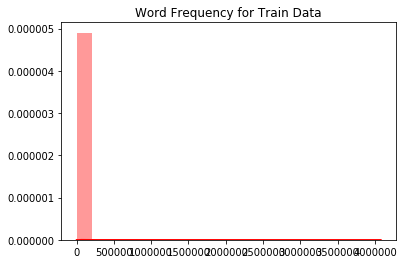

In [90]:
sns.distplot(wordsForHist, bins=20, color = 'red').set_title('Word Frequency for Train Data')

In [91]:
wordFreq2 = defaultdict(int)

wordData2 = list(train_data['sentenceWords_Stops'])

for row in wordData2:
    for word in row:
        wordFreq2[word] += 1      

In [92]:
wordsForHist2 = list(wordFreq2.values())

/home/lance_miles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Word Frequency for Train Data')

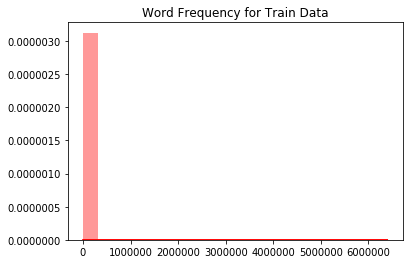

In [93]:
sns.distplot(wordsForHist2, bins=20, color = 'red').set_title('Word Frequency for Train Data')

In [94]:
reviewLength = []

for row in wordData:
    reviewLength.append(len(row))

/home/lance_miles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Sentence Lengths for Train Data')

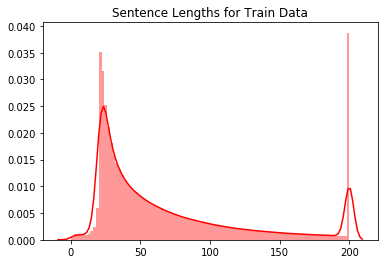

In [95]:
sns.distplot(reviewLength, bins=100, color = 'red').set_title('Sentence Lengths for Train Data')

In [96]:
print('Mean:',np.mean(reviewLength))
print('Median:',np.median(reviewLength))

Mean: 68.83632083333333
Median: 47.0


In [97]:
reviewLength2 = []

for row in wordData2:
    reviewLength2.append(len(row))

/home/lance_miles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Sentence Lengths for Train Data')

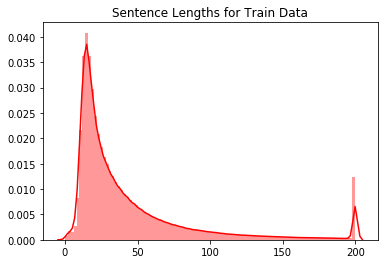

In [98]:
sns.distplot(reviewLength2, bins=100, color = 'red').set_title('Sentence Lengths for Train Data')

In [99]:
print('Mean:',np.mean(reviewLength2))
print('Median:',np.median(reviewLength2))

Mean: 42.20296916666667
Median: 26.0


In [100]:
num_sents = []

reviewSents = train_data['sentences_indiv']
print(list(train_data['reviewText'][4:5]))
print(list(train_data['sentences'][4:5]))
print(list(reviewSents[4:5]))

for sents in reviewSents:
    num_sents.append(len(sents))

["There is no suction on this little vacuum cleaner....it just doesn't work. No, I would not recommend it to anyone."]
['there is no suction on this little vacuum cleaner it just does not work no i would not recommend it to anyone']
[['there is no suction on this little vacuum cleaner ', ' it just does not work ', ' no i would not recommend it to anyone ', ' ']]


/home/lance_miles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Number of Sentences for Train Data')

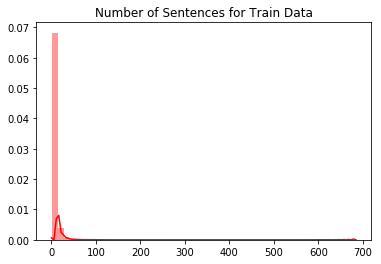

In [101]:
sns.distplot(num_sents, bins=50, color = 'red').set_title('Number of Sentences for Train Data')

In [102]:
print('Mean:',np.mean(num_sents))
print('Median:',np.median(num_sents))

Mean: 6.654093333333333
Median: 5.0


## Universal Sentence Encoder

In [22]:
#embedding = hub.Module("https://tfhub.dev/google/universal-sentence-encoder-large/3")

embedding = hub.Module("https://tfhub.dev/google/universal-sentence-encoder/2")

In [23]:
def getUniSentEmbeds(data):

    tf.logging.set_verbosity(tf.logging.ERROR)

    with tf.Session() as sess:
        sess.run([tf.global_variables_initializer(), tf.tables_initializer()])
        review_embeddings = sess.run(embedding((data)))

    review_embeddings = np.array(review_embeddings)
    return review_embeddings

In [24]:
def loadUniSentEncod(data, link):

    try:
        data_USE = np.load(link)
        print(f'Successfully opened data from {link}')

    except FileNotFoundError:

        data_reviews = [str(rev) for rev in data['sentences']]

        print('Build Universal Sentence Encoder Data')
        data_USE = getUniSentEmbeds(data_reviews)

        np.save(link, data_USE)

        print(f'Finished pickling data for future use as {link}.')
        
    return data_USE

In [60]:
#Load universal sentence encoder embeddings for play data
play_data_link = '../../play_data_USE.npy'
play_data_USE = loadUniSentEncod(play_data,play_data_link)

test_data_name = '../../test_data_USE.npy'
test_data_USE = loadUniSentEncod(test_data,test_data_name)

train_data_name = '../../train_data_USE.npy'
train_data_USE = loadUniSentEncod(train_data,train_data_name)

imdb_test_data_name = '../../imdb_test_data_USE.npy'
imdb_test_USE = loadUniSentEncod(imdb_test,imdb_test_data_name)

imdb_train_data_name = '../../imdb_train_data_USE.npy'
imdb_train_USE = loadUniSentEncod(imdb_train,imdb_train_data_name)

twitter_data_name = '../../twitter_data_USE.npy'
twitter_test_USE = loadUniSentEncod(twitter_reviews,twitter_data_name)

yelp_data_name = '../../yelp_data_USE.npy'
yelp_test_USE = loadUniSentEncod(yelp_reviews,yelp_data_name)

yelp_data_name = '../../yelp_zhang_train_USE.npy'
yelp_zhang_train_USE = loadUniSentEncod(yelp_zhang_train,yelp_data_name)

yelp_data_name = '../../yelp_zhang_test_USE.npy'
yelp_zhang_test_USE = loadUniSentEncod(yelp_zhang_test,yelp_data_name)

amazon_data_name = '../../amazon_zhang_test_USE.npy'
amazon_zhang_test_USE = loadUniSentEncod(amazon_zhang_test,amazon_data_name)

sst_data_name = '../../sst_test_USE.npy'
sst_test_USE = loadUniSentEncod(sst_test,sst_data_name)

Successfully opened data from ../../play_data_USE.npy
Successfully opened data from ../../test_data_USE.npy
Successfully opened data from ../../train_data_USE.npy
Successfully opened data from ../../imdb_test_data_USE.npy
Successfully opened data from ../../imdb_train_data_USE.npy
Successfully opened data from ../../twitter_data_USE.npy
Successfully opened data from ../../yelp_data_USE.npy
Successfully opened data from ../../yelp_zhang_train_USE.npy
Successfully opened data from ../../yelp_zhang_test_USE.npy
Successfully opened data from ../../amazon_zhang_test_USE.npy
Build Universal Sentence Encoder Data
Finished pickling data for future use as ../../sst_test_USE.npy.


## Sentence level USE

In [25]:
play_data.head()

,Product,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,sentiment,summary,unixReviewTime,sentenceWords_Stops,sentences_indiv,sentenceWords,sentences
83381,reviews_Electronics,B00AHPSTRY,"[5, 5]",1.0,just received my screen protector. it's going...,"08 14, 2013",A20EOZ5Q2Z8L1S,Vicki B.,0,SENDING IT BACK!,1376438400,"[received, screen, protector, ., going, back, ...","[just received my screen protector , it is go...","[just, received, my, screen, protector, it, is...",just received my screen protector it is going ...
7113,reviews_CDs_and_Vinyl,B00005AQ38,"[6, 6]",1.0,"But instead of the orchestra, we are treated t...","12 23, 2001",A16SS8HYJW7IEJ,"Mark Pollock ""educator""",0,Would be nice to hear the orchestra...,1009065600,"[instead, orchestra, treated, wonderful, sound...",[but instead of the orchestra we are treated t...,"[but, instead, of, the, orchestra, we, are, tr...",but instead of the orchestra we are treated to...
58166,reviews_Health_and_Personal_Care,B0007P2OO8,"[0, 0]",5.0,Love this shaving soap and it was the best pri...,"01 15, 2013",A16O37AEI0Y3N,Richard Papaleo,1,Col. Conk is Famous,1358208000,"[love, shaving, soap, best, price, ., gives, b...",[love this shaving soap and it was the best pr...,"[love, this, shaving, soap, and, it, was, the,...",love this shaving soap and it was the best pri...
35717,reviews_Home_and_Kitchen,B000AA89GW,"[0, 1]",1.0,It is impossible to join the two pieces of the...,"08 28, 2011",A2OV0337VRTSUV,AF,0,Impossible to close tightly... Makes a mess!!!,1314489600,"[impossible, join, two, pieces, cappuccino, ma...",[it is impossible to join the two pieces of th...,"[it, is, impossible, to, join, the, two, piece...",it is impossible to join the two pieces of the...
26850,reviews_Electronics,B00529F3JW,"[2, 2]",1.0,There is no suction on this little vacuum clea...,"01 25, 2013",A3I0B7SO7OE7YG,Terry White,0,Mini Vacuum Cleaner,1359072000,"[suction, little, vacuum, cleaner, ., work, .,...",[there is no suction on this little vacuum cle...,"[there, is, no, suction, on, this, little, vac...",there is no suction on this little vacuum clea...


In [26]:
def getUniSentEmbeds_sents(data):

    tf.logging.set_verbosity(tf.logging.ERROR)

    with tf.Session() as sess:
        sess.run([tf.global_variables_initializer(), tf.tables_initializer()])
        
        review_embeddings = sess.run(embedding((data)))

    review_embeddings = np.array(review_embeddings)
    return review_embeddings

In [ ]:
sent_length = 5

data_reviews = [[rev] for rev in play_data['sentences_indiv']]

test_outputs = data_reviews
new_dat = []

for rev in test_outputs:
    for sents in rev:
        if len(sents) < sent_length:
           # print('entered')
            sents.append(' ')
            sents.append(' ')
            sents.append(' ')
            sents.append(' ')
           # print('done')
            
        new_dat.append(sents[:sent_length])
np.array(new_dat)


# for revs in new_dat[:2]:
#      check = getUniSentEmbeds_sents(revs)

In [ ]:
check = np.zeros()

In [30]:
test_array = np.array(test_this[0])
test_array

test_array2 = np.array(new_dat[1])
test_array2

new_test_array = np.concatenate((test_array,test_array2), axis = 0)
new_test_array
new_test_array.shape

(10,)

In [ ]:
sent_length = 5


def loadUniSentEncod_sents(data, link, sent_length = sent_length):

    try:
        data_USE = np.load(link)
        print(f'Successfully opened data from {link}')

    except FileNotFoundError:

        data_reviews = [[rev] for rev in data['sentences_indiv']]
        data_USE = []
        for rev in data_reviews:
            if len(rev) < 5:
                rev.append(' ')
                rev.append(' ')
                rev.append(' ')
                rev.append(' ')
                

        print('Build Universal Sentence Encoder Data')
            interim = getUniSentEmbeds_sents(rev[:])

        np.save(link, data_USE)

        print(f'Finished pickling data for future use as {link}.')
        
    return data_USE

## Keras

### TO DO:

**Model Efforts**
* Initialize and access word2vec embeddings in CNN
* Initialize and access glove embeddings in CNN
* Index Universal Sentence Embeddings for concatenation in CNN

**Text Processing**
* Contractions
* Review Length (some as large as 6000?!)
* Stopwords

### Baseline Models
#### CNN
* Trained Embeddings
* Word2Vec
* Glove

#### Softmax
* Universal Sentence Encoder (USE)

### Models to Test
#### CNN (Concatentation)
* Trained Embeddings + USE
* Word2Vec + USE
* Glove + USE

**If extra time**
* Zero shot learning - IMDB Reviews
* Sentiment embeddings

In [ ]:
train_data.head()

In [ ]:
yelp_zhang_train.head()

In [59]:
max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)

list_sentences_train = list(train_data['sentenceWords'])

tokenizer = Tokenizer()   #num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)

word_index = tokenizer.word_index

vocabulary_size = len(word_index) + 1
vocabulary_size

embedDim=300

def standardizeData(data, tokenModel = tokenizer):
    dataSentences = list(data['sentenceWords'])
    list_token_data = tokenModel.texts_to_sequences(dataSentences)
    
    data_tokenized = pad_sequences(list_token_data, maxlen=max_length, padding='post')
    data_labels = np.array(data['sentiment'])
    
    return data_tokenized, data_labels

X_train, X_train_labels = standardizeData(train_data)
X_test, X_test_labels = standardizeData(test_data)
X_imdb_train, X_imdb_train_labels = standardizeData(imdb_train)
X_imdb_test, X_imdb_test_labels = standardizeData(imdb_test)
X_twitter_test, X_twitter_test_labels = standardizeData(twitter_reviews)
X_yelp_test, X_yelp_test_labels = standardizeData(yelp_reviews)
X_yelp_zhang_train, X_yelp_zhang_train_labels = standardizeData(yelp_zhang_train)
X_yelp_zhang_test, X_yelp_zhang_test_labels = standardizeData(yelp_zhang_test)
X_amazon_zhang_test, X_amazon_zhang_test_labels = standardizeData(amazon_zhang_test)

sst_dataSentences = list(sst_test['sentenceWords'])

sst_list_token_data = tokenizer.texts_to_sequences(sst_dataSentences)

X_sst_test = pad_sequences(sst_list_token_data, maxlen=max_length, padding='post')

## Word2Vec Embeddings

In [32]:
#https://www.kaggle.com/umbertogriffo/cnn-yoon-kim-s-model-and-google-s-word2vec-model
#https://www.kaggle.com/marijakekic/cnn-in-keras-with-pretrained-word2vec-weights

def loadw2v(loadEmbed = True):
    if loadEmbed == True:
        w2v_embed_name = '../../w2v_embed.npy'
        embedding_matrix_w2v = np.load(w2v_embed_name)

        print('Successfully opened pickled embedding_matrix_w2v')
        return embedding_matrix_w2v
    else:
        
        word_vectors = KeyedVectors.load_word2vec_format('../../GoogleNews-vectors-negative300.bin.gz', binary=True)
        embedding_matrix_w2v = np.zeros((vocabulary_size, embedDim))
        
        for word, i in word_index.items():
            try:
                embedding_vector = word_vectors[word]
                embedding_matrix_w2v[i] = embedding_vector
            except KeyError:
                embedding_matrix_w2v[i]=np.random.normal(0,np.sqrt(0.25),embedDim)

        del(word_vectors)
        
        w2v_embed_name = '../../w2v_embed.npy'
        np.save(w2v_embed_name, embedding_matrix_w2v)
        
        return embedding_matrix_w2v

embedding_matrix_w2v = loadw2v(loadEmbed = True)

Successfully opened pickled embedding_matrix_w2v


In [33]:
embedding_matrix_w2v

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.08007812,  0.10498047,  0.04980469, ...,  0.00366211,
         0.04760742, -0.06884766],
       [-0.22558594, -0.01953125,  0.09082031, ...,  0.02819824,
        -0.17773438, -0.00604248],
       ...,
       [-0.05669782,  0.66833448, -0.72440838, ...,  0.02165054,
         0.02798013, -0.29262374],
       [-0.44889479, -0.14608567,  0.41548637, ...,  0.01506322,
        -0.41868808,  0.33303135],
       [ 0.09562571, -0.18635412, -0.26843286, ..., -0.53592383,
         0.25208398, -0.16169312]])

In [34]:
embedding_matrix_w2v.shape

(385239, 300)

## Glove Embeddings

In [35]:
#https://www.kaggle.com/umbertogriffo/cnn-yoon-kim-s-model-and-google-s-word2vec-model
#https://www.kaggle.com/marijakekic/cnn-in-keras-with-pretrained-word2vec-weights

# https://stackoverflow.com/questions/37793118/load-pretrained-glove-vectors-in-python
# import warnings
# # warnings.filterwarnings("ignore")

# _ = glove2word2vec(glove_input_file='../../glove.840B.300d.txt', 
#                    word2vec_output_file='../../gensim_glove_vectors.txt')

In [36]:
def loadGlove(loadEmbed = True):
    if loadEmbed == True:
        glove_embed_name = '../../glove_embed.npy'
        embedding_matrix_glove = np.load(glove_embed_name)

        print('Successfully opened pickled embedding_matrix_glove')
        return embedding_matrix_glove
    
    else:
        word_vectors = KeyedVectors.load_word2vec_format('../../gensim_glove_vectors.txt', binary=False)

        embedding_matrix_glove = np.zeros((vocabulary_size, embedDim))
        for word, i in word_index.items():
            try:
                embedding_vector = word_vectors[word]
                embedding_matrix_glove[i] = embedding_vector
            except KeyError:
                embedding_matrix_glove[i]=np.random.normal(0,np.sqrt(0.25),embedDim)

        del(word_vectors)
        
        glove_embed_name = '../../glove_embed.npy'
        np.save(glove_embed_name, embedding_matrix_glove)
        
        return embedding_matrix_glove

embedding_matrix_glove = loadGlove(loadEmbed = True)

Successfully opened pickled embedding_matrix_glove


In [37]:
embedding_matrix_glove

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.27204001, -0.06203   , -0.1884    , ...,  0.13015001,
        -0.18317001,  0.1323    ],
       [ 0.18732999,  0.40595001, -0.51174003, ...,  0.16495   ,
         0.18757001,  0.53873998],
       ...,
       [-0.38305282,  0.51873904,  0.42807558, ..., -0.06607605,
         0.51693713,  0.53094775],
       [-0.00126892, -0.1897983 ,  0.0538873 , ..., -0.23339596,
        -0.33180575,  0.02143054],
       [ 0.95435669,  0.0096887 , -0.26980815, ...,  0.11325344,
        -0.11042341, -0.13675645]])

In [38]:
embedding_matrix_glove.shape

(385239, 300)

## CNN Model

In [ ]:
# https://machinelearningmastery.com/develop-n-gram-multichannel-convolutional-neural-network-sentiment-analysis/

def CreateKimCNN(kernelSize=[4, 5, 6], numFilters=128, embedDepth=300, 
                 dropOut=0.5, embeds=None, use=True, length=max_length,
                 vocab=vocabulary_size, pool=2, denseInputs=10, train=False):
    
    k1 = kernelSize[0]
    k2 = kernelSize[1]
    k3 = kernelSize[2]
    
    k1_inputs = Input(shape=(length,))
    k2_inputs = Input(shape=(length,))
    k3_inputs = Input(shape=(length,))
       
    if embeds == None:
        k1_embeddings = Embedding(vocab, embedDepth)(k1_inputs)
        k2_embeddings = Embedding(vocab, embedDepth)(k2_inputs)
        k3_embeddings = Embedding(vocab, embedDepth)(k3_inputs)

    elif embeds == 'w2v':
        k1_embeddings = Embedding(vocab,
                            300,
                            weights=[embedding_matrix_w2v],
                            trainable=train)(k1_inputs)
        k2_embeddings = Embedding(vocab,
                            300,
                            weights=[embedding_matrix_w2v],
                            trainable=train)(k2_inputs)
        k3_embeddings = Embedding(vocab,
                            300,
                            weights=[embedding_matrix_w2v],
                            trainable=train)(k3_inputs)
        
    elif embeds == 'Glove':
        k1_embeddings = Embedding(vocab,
                            300,
                            weights=[embedding_matrix_glove],
                            trainable=train)(k1_inputs)
        k2_embeddings = Embedding(vocab,
                            300,
                            weights=[embedding_matrix_glove],
                            trainable=train)(k2_inputs)
        k3_embeddings = Embedding(vocab,
                            300,
                            weights=[embedding_matrix_glove],
                            trainable=train)(k3_inputs)
    else:
        print('Specify embeds correctly. Currently embeds =',embeds)
        return
    
    k1_conv = Conv1D(filters=numFilters, kernel_size=k1, activation='relu')(k1_embeddings)
    k1_dropout = Dropout(dropOut)(k1_conv)
    k1_maxPool = MaxPooling1D(pool_size=pool)(k1_dropout)
    k1_flatten = Flatten()(k1_maxPool)

    k2_conv = Conv1D(filters=numFilters, kernel_size=k2, activation='relu')(k2_embeddings)
    k2_dropout = Dropout(dropOut)(k2_conv)
    k2_maxPool = MaxPooling1D(pool_size=pool)(k2_dropout)
    k2_flatten = Flatten()(k2_maxPool)

    k3_conv = Conv1D(filters=numFilters, kernel_size=k3, activation='relu')(k3_embeddings)
    k3_dropout = Dropout(dropOut)(k3_conv)
    k3_maxPool = MaxPooling1D(pool_size=pool)(k3_dropout)
    k3_flatten = Flatten()(k3_maxPool)

    if use == True:
        use_inputs = Input(shape=(512,))
        concat_kern = concatenate([k1_flatten, k2_flatten, k3_flatten, use_inputs])
    else:
        concat_kern = concatenate([k1_flatten, k2_flatten, k3_flatten])
        
    denseLayer = Dense(denseInputs, activation='relu')(concat_kern)
    cnnOutputs = Dense(1, activation='sigmoid')(denseLayer)
    
    if use == True:
        model = Model(inputs=[k1_inputs, k2_inputs, k3_inputs, use_inputs], outputs=cnnOutputs)
    else:
        model = Model(inputs=[k1_inputs, k2_inputs, k3_inputs], outputs=cnnOutputs)
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    #https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
    # simple early stopping
#     es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
#     mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
    
    print(model.summary())
        
    #plot_model(model, show_shapes=True, to_file='CNNModel.png')
        
    return model


## Simple Softmax for Baseline USE Outputs

In [ ]:
def simpleSoft(length=512, act = 'relu', denseInputs=10):
    
    universalEmbeddings = Input(shape=(length,))
    
    denseLayer = Dense(denseInputs, activation=act)(universalEmbeddings)
    denseOutputs = Dense(1, activation='sigmoid')(denseLayer)
    
    model = Model(inputs=[universalEmbeddings], outputs=denseOutputs)
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
 
    print(model.summary())
                
    return model

In [54]:
simpleSoftUSE = simpleSoft(denseInputs=20)

simpleSoftUSE.fit([train_data_USE], X_train_labels, epochs=5, batch_size=5000)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 20)                10260     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 21        
Total params: 10,281
Trainable params: 10,281
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
1200000/1200000 [==============================] - 5s 4us/step - loss: 0.3937 - acc: 0.8581
Epoch 2/5
1200000/1200000 [==============================] - 3s 3us/step - loss: 0.2609 - acc: 0.8949
Epoch 3/5
1200000/1200000 [==============================] - 3s 3us/step - loss: 0.2509 - acc: 0.8987
Epoch 4/5
1200000/1200000 [==============================] - 3s 3us/step - loss: 0.2467 - a

In [55]:
simpleSoftUSE.save('../../SimpleSoftmax_USE.h5')

In [56]:
simpleSoftUSE = load_model('../../SimpleSoftmax_USE.h5')

In [57]:
train_acc = simpleSoftUSE.evaluate([train_data_USE], X_train_labels, verbose=0)

In [58]:
test_acc = simpleSoftUSE.evaluate([test_data_USE], X_test_labels, verbose=0)

In [59]:
print('Simple Dense Layer to Softmax Accuracy using USE\nTrain: %.3f, Test: %.3f' % (train_acc[1], test_acc[1]))

Simple Dense Layer to Softmax Accuracy using USE
Train: 0.902, Test: 0.899


## Build and Evaluate CNN w/ Glove + USE

In [34]:
#embeds can be None, 'w2v', or 'Glove'
#if use is True, you need to adjust the cnnModel.fit to include the USE outputs as an input

cnnModel = CreateKimCNN(kernelSize=[4, 5, 6], numFilters=128, embedDepth=300, 
                 dropOut=0.5, embeds='Glove', use=True, length=max_length,
                 pool=2, denseInputs=10, train=False)

cnnModel.fit([X_train,X_train,X_train, train_data_USE], X_train_labels, epochs=3, batch_size=5000)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 200, 300)     115571700   input_1[0][0]                    
__________________________________________________________________________________________________
embedding_

In [39]:
cnnModel.save('../../CNNModel_200MaxL_Glove_USE.h5')

In [ ]:
cnnModel = load_model('../../CNNModel_200MaxL_Glove_USE.h5')

In [ ]:
train_acc = cnnModel.evaluate([X_train, X_train, X_train, train_data_USE], X_train_labels, verbose=0)

In [29]:
train_acc

0.9668933333333334

In [35]:
test_acc = cnnModel.evaluate([X_test, X_test, X_test, test_data_USE], X_test_labels, verbose=0)

In [36]:
print('CNN Model Accuracy using Glove + USE\nTrain: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.967, Test: 0.966


## Build and Evaluate CNN w/ Glove

In [39]:
cnnModel2 = CreateKimCNN(kernelSize=[4, 5, 6], numFilters=128, embedDepth=300, 
                 dropOut=0.5, embeds='Glove', use=False, length=max_length,
                 vocab = vocabulary_size, pool = 2, denseInputs = 10)

cnnModel2.fit([X_train,X_train,X_train], X_train_labels, epochs=3, batch_size=5000)

cnnModel2.save('../../CNNModel_200MaxL_Glove.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 200, 300)     115571700   input_5[0][0]                    
__________________________________________________________________________________________________
embedding_

In [45]:
cnnModel2 = load_model('../../CNNModel_200MaxL_Glove.h5')

In [47]:
train_acc = cnnModel2.evaluate([X_train, X_train, X_train], X_train_labels, verbose=0)
train_acc

[0.304349864111344, 0.9415758333333333]

In [48]:
test_acc = cnnModel2.evaluate([X_test, X_test, X_test], X_test_labels, verbose=0)
test_acc

[0.304349864111344, 0.9415758333333333]

In [49]:
print('CNN Model Accuracy using Glove\nTrain: %.3f, Test: %.3f' % (train_acc[1], test_acc[1]))

CNN Model Accuracy using Glove
Train: 0.942, Test: 0.942


## Build and Evaluate CNN w/ word2vec

In [50]:
cnnModel3 = CreateKimCNN(kernelSize=[4, 5, 6], numFilters=128, embedDepth=300, 
                 dropOut=0.5, embeds='w2v', use=False, length=max_length,
                 vocab = vocabulary_size, pool = 2, denseInputs = 10)

cnnModel3.fit([X_train,X_train,X_train], X_train_labels, epochs=3, batch_size=5000)

cnnModel3.save('../../CNNModel_200MaxL_w2v.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 200)          0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 200)          0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 200, 300)     115571700   input_11[0][0]                   
__________________________________________________________________________________________________
embedding_

In [ ]:
cnnModel3 = load_model('../../CNNModel_200MaxL_w2v.h5')

In [51]:
train_acc = cnnModel3.evaluate([X_train, X_train, X_train], X_train_labels, verbose=0)
train_acc

[0.29983700858175755, 0.9432]

In [52]:
test_acc = cnnModel3.evaluate([X_test, X_test, X_test], X_test_labels, verbose=0)
test_acc

[0.29983700858175755, 0.9432]

In [54]:
print('CNN Model Accuracy using w2v\nTrain: %.3f, Test: %.3f' % (train_acc[1], test_acc[1]))

CNN Model Accuracy using w2v
Train: 0.943, Test: 0.943


In [39]:
cnnModel4 = CreateKimCNN(kernelSize=[4, 5, 6], numFilters=128, embedDepth=300, 
                 dropOut=0.5, embeds='w2v', use=True, length=max_length,
                 vocab = vocabulary_size, pool = 2, denseInputs = 10)

cnnModel4.fit([X_train, X_train, X_train, train_data_USE], X_train_labels, epochs=3, batch_size=5000)

cnnModel4.save('../../CNNModel_200MaxL_w2v_USE.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 200)          0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           (None, 200)          0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 200, 300)     115571700   input_12[0][0]                   
__________________________________________________________________________________________________
embedding_

In [40]:
cnnModel4 = load_model('../../CNNModel_200MaxL_w2v_USE.h5')

In [41]:
train_acc = cnnModel4.evaluate([X_train, X_train, X_train, train_data_USE], X_train_labels, verbose=0)
train_acc

[0.2875843709284067, 0.9511316666666667]

In [42]:
test_acc = cnnModel4.evaluate([X_train, X_train, X_train, train_data_USE], X_test_labels, verbose=0)
test_acc

print('CNN Model Accuracy using w2v + USE\nTrain: %.3f, Test: %.3f' % (train_acc[1], test_acc[1]))

CNN Model Accuracy using w2v + USE
Train: 0.951, Test: 0.951


In [43]:
cnnModel5 = CreateKimCNN(kernelSize=[4, 5, 6], numFilters=128, embedDepth=300, 
                 dropOut=0.5, embeds=None, use=False, length=max_length,
                 vocab = vocabulary_size, pool = 2, denseInputs = 10)

cnnModel5.fit([X_train, X_train, X_train], X_train_labels, epochs=3, batch_size=5000)

cnnModel5.save('../../CNNModel_200MaxL_None.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 200)          0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           (None, 200)          0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 200, 300)     115571700   input_16[0][0]                   
__________________________________________________________________________________________________
embedding_

/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/la

Epoch 1/3
1200000/1200000 [==============================] - 2117s 2ms/step - loss: 0.2655 - acc: 0.8730
Epoch 2/3
1200000/1200000 [==============================] - 2097s 2ms/step - loss: 0.1238 - acc: 0.9554
Epoch 3/3
1200000/1200000 [==============================] - 2091s 2ms/step - loss: 0.0898 - acc: 0.9697


In [33]:
cnnModel5 = load_model('../../CNNModel_200MaxL_None.h5')

/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/la

In [35]:
train_acc = cnnModel5.evaluate([X_train, X_train, X_train], X_train_labels, verbose=0)
train_acc

[0.08358829655398925, 0.9767966666666666]

In [ ]:
test_acc = cnnModel5.evaluate([X_train, X_train, X_train], X_test_labels, verbose=0)
test_acc

In [36]:
print('CNN Model Accuracy using trained Embeddings\nTrain: %.3f, Test: %.3f' % (train_acc[1], test_acc[1]))

CNN Model Accuracy using trained Embeddings
Train: 0.977, Test: 0.977


In [35]:
cnnModel6 = CreateKimCNN(kernelSize=[4, 5, 6], numFilters=128, embedDepth=300, 
                 dropOut=0.5, embeds=None, use=True, length=max_length,
                 vocab = vocabulary_size, pool = 2, denseInputs = 10)

cnnModel6.fit([X_train, X_train, X_train, train_data_USE], X_train_labels, epochs=3, batch_size=5000)

cnnModel6.save('../../CNNModel_200MaxL_None_USE.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 200, 300)     115571700   input_5[0][0]                    
__________________________________________________________________________________________________
embedding_

/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/la

Epoch 1/3
1200000/1200000 [==============================] - 2138s 2ms/step - loss: 0.2354 - acc: 0.8950
Epoch 2/3
1200000/1200000 [==============================] - 2096s 2ms/step - loss: 0.1209 - acc: 0.9567
Epoch 3/3
1200000/1200000 [==============================] - 2112s 2ms/step - loss: 0.0869 - acc: 0.9708


In [36]:
cnnModel6 = load_model('../../CNNModel_200MaxL_None_USE.h5')

/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/la

In [37]:
train_acc = cnnModel6.evaluate([X_train, X_train, X_train, train_data_USE], X_train_labels, verbose=0)
train_acc

[0.07395656862472494, 0.9802225]

In [38]:
test_acc = cnnModel6.evaluate([X_train, X_train, X_train, train_data_USE], X_test_labels, verbose=0)
test_acc

print('CNN Model Accuracy using trained Embeddings\nTrain: %.3f, Test: %.3f' % (train_acc[1], test_acc[1]))

CNN Model Accuracy using trained Embeddings
Train: 0.980, Test: 0.980


## Test Models on Test Datasets

In [41]:
modelList = ['SimpleSoftmax_USE.h5',
             'CNNModel_200MaxL_None.h5', 'CNNModel_200MaxL_None_USE.h5',
             'CNNModel_200MaxL_Glove.h5', 'CNNModel_200MaxL_Glove_USE.h5',
             'CNNModel_200MaxL_w2v.h5', 'CNNModel_200MaxL_w2v_USE.h5']

nameList = ['Simple Dense to Softmax with USE',
            'CNN - Trained Embeddings', 'CNN - Trained Embeddings + USE',
            'CNN - Glove Embeddings', 'CNN - Glove Embeddings + USE',
            'CNN - Word2Vec Embeddings', 'CNN - Word2Vec Embeddings + USE']

USE_bool = [True, False, True, False, True, False, True]

simple = [True, False, False, False, False, False, False]

col_name = ['USE_Soft','CNN_TE','CNN_TE_USE','CNN_Glove','CNN_Glove_USE','CNN_w2V','CNN_w2V_USE']

def loadModels(data, use_outputs, data_labels, pdData, model = modelList, 
               name = nameList, simp = simple, USE = USE_bool, 
               cols=col_name, verb=False):        
    
    accuracies = []
    
    dat_pd = pdData
    for trainedModel, name, USE_embeds,sim, col in zip(model, name, USE, simp, cols):
        print(f'Loading: {trainedModel}')
        
        cnnModel = load_model(f'../../{trainedModel}')
            
        if USE_embeds == True:
            
            if sim == True:
                imdbAcc = cnnModel.evaluate([use_outputs], data_labels, verbose=0)
                preds = cnnModel.predict([use_outputs], verbose=0)
                
            else:
                imdbAcc = cnnModel.evaluate([data, data, data, use_outputs], data_labels, verbose=0)
                preds = cnnModel.predict([data, data, data, use_outputs], verbose=0)
        else:
            imdbAcc = cnnModel.evaluate([data, data, data], data_labels, verbose=0)
            preds = cnnModel.predict([data, data, data], verbose=0)

        if verb == True:
            print(f'{name}\n Test: %.3f' % (imdbAcc[1]))
        
        accuracies.extend([imdbAcc])
        dat_pd[col]=preds[:]
        del(cnnModel)
    return accuracies, dat_pd

### IMDB Datasets

In [42]:
imdb_zero_shot, imdb_results = loadModels(pdData=imdb_test, 
                            data=X_imdb_test, use_outputs=imdb_test_USE, 
                            data_labels=X_imdb_test_labels)

for acc,name in zip(imdb_zero_shot,nameList):
    print(f'{name}\nAccuracy on IMDB Test: {acc[1]}\n_______________________\n')

Loading: SimpleSoftmax_USE.h5
Loading: CNNModel_200MaxL_None.h5


/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/la

Loading: CNNModel_200MaxL_None_USE.h5


/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/la

Loading: CNNModel_200MaxL_Glove.h5
Loading: CNNModel_200MaxL_Glove_USE.h5
Loading: CNNModel_200MaxL_w2v.h5
Loading: CNNModel_200MaxL_w2v_USE.h5
Simple Dense to Softmax with USE
Accuracy on IMDB Test: 0.79696
_______________________

CNN - Trained Embeddings
Accuracy on IMDB Test: 0.82176
_______________________

CNN - Trained Embeddings + USE
Accuracy on IMDB Test: 0.85516
_______________________

CNN - Glove Embeddings
Accuracy on IMDB Test: 0.82912
_______________________

CNN - Glove Embeddings + USE
Accuracy on IMDB Test: 0.86076
_______________________

CNN - Word2Vec Embeddings
Accuracy on IMDB Test: 0.84524
_______________________

CNN - Word2Vec Embeddings + USE
Accuracy on IMDB Test: 0.8522
_______________________



## Test Twitter (Sentiment140) Data

In [43]:
# twitter_zero_shot = loadModels(modelList, nameList, simple, USE_bool, 
#                             X_twitter_test, twitter_test_USE, X_twitter_test_labels)
twitter_zero_shot, twitter_results = loadModels(pdData=twitter_reviews, 
                            data=X_twitter_test, use_outputs=twitter_test_USE, 
                            data_labels=X_twitter_test_labels)

for acc,name in zip(twitter_zero_shot,nameList):
    print(f'{name}\nAccuracy on Twitter Test: {acc[1]}\n_______________________\n')

Loading: SimpleSoftmax_USE.h5
Loading: CNNModel_200MaxL_None.h5


/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/la

Loading: CNNModel_200MaxL_None_USE.h5


/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/la

Loading: CNNModel_200MaxL_Glove.h5
Loading: CNNModel_200MaxL_Glove_USE.h5
Loading: CNNModel_200MaxL_w2v.h5
Loading: CNNModel_200MaxL_w2v_USE.h5
Simple Dense to Softmax with USE
Accuracy on Twitter Test: 0.6692333333333333
_______________________

CNN - Trained Embeddings
Accuracy on Twitter Test: 0.6389666666666667
_______________________

CNN - Trained Embeddings + USE
Accuracy on Twitter Test: 0.6479666666666667
_______________________

CNN - Glove Embeddings
Accuracy on Twitter Test: 0.6583
_______________________

CNN - Glove Embeddings + USE
Accuracy on Twitter Test: 0.6771166666666667
_______________________

CNN - Word2Vec Embeddings
Accuracy on Twitter Test: 0.6557833333333334
_______________________

CNN - Word2Vec Embeddings + USE
Accuracy on Twitter Test: 0.67865
_______________________



## Test Yelp Data

In [44]:
# yelp_zero_shot, yelp_results = loadModels(modelList, nameList, simple, USE_bool, 
#                             X_yelp_test, yelp_test_USE, X_yelp_test_labels)

yelp_zero_shot, yelp_results = loadModels(pdData=yelp_reviews, 
                            data=X_yelp_test, use_outputs=yelp_test_USE, 
                            data_labels=X_yelp_test_labels)

for acc,name in zip(yelp_zero_shot,nameList):
    print(f'{name}\nAccuracy on Yelp Test: {acc[1]}\n_______________________\n')

Loading: SimpleSoftmax_USE.h5
Loading: CNNModel_200MaxL_None.h5


/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/la

Loading: CNNModel_200MaxL_None_USE.h5


/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/la

Loading: CNNModel_200MaxL_Glove.h5
Loading: CNNModel_200MaxL_Glove_USE.h5
Loading: CNNModel_200MaxL_w2v.h5
Loading: CNNModel_200MaxL_w2v_USE.h5
Simple Dense to Softmax with USE
Accuracy on Yelp Test: 0.9179666666666667
_______________________

CNN - Trained Embeddings
Accuracy on Yelp Test: 0.9534833333333333
_______________________

CNN - Trained Embeddings + USE
Accuracy on Yelp Test: 0.9538166666666666
_______________________

CNN - Glove Embeddings
Accuracy on Yelp Test: 0.9533333333333334
_______________________

CNN - Glove Embeddings + USE
Accuracy on Yelp Test: 0.9586
_______________________

CNN - Word2Vec Embeddings
Accuracy on Yelp Test: 0.9546666666666667
_______________________

CNN - Word2Vec Embeddings + USE
Accuracy on Yelp Test: 0.9592666666666667
_______________________



In [45]:
yelp_Zhang_zero_shot, yelp_zhang_results = loadModels(pdData=yelp_zhang_test, 
                            data=X_yelp_zhang_test, use_outputs=yelp_zhang_test_USE, 
                            data_labels=X_yelp_zhang_test_labels)

for acc,name in zip(yelp_Zhang_zero_shot,nameList):
    print(f'{name}\nAccuracy on Yelp Zhang Test: {acc[1]}\n_______________________\n')

Loading: SimpleSoftmax_USE.h5
Loading: CNNModel_200MaxL_None.h5


/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/la

Loading: CNNModel_200MaxL_None_USE.h5


/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/la

Loading: CNNModel_200MaxL_Glove.h5
Loading: CNNModel_200MaxL_Glove_USE.h5
Loading: CNNModel_200MaxL_w2v.h5
Loading: CNNModel_200MaxL_w2v_USE.h5
Simple Dense to Softmax with USE
Accuracy on Yelp Zhang Test: 0.8395526315789473
_______________________

CNN - Trained Embeddings
Accuracy on Yelp Zhang Test: 0.9017105263157895
_______________________

CNN - Trained Embeddings + USE
Accuracy on Yelp Zhang Test: 0.9052894736842105
_______________________

CNN - Glove Embeddings
Accuracy on Yelp Zhang Test: 0.9033947368421053
_______________________

CNN - Glove Embeddings + USE
Accuracy on Yelp Zhang Test: 0.9065
_______________________

CNN - Word2Vec Embeddings
Accuracy on Yelp Zhang Test: 0.8998684210526315
_______________________

CNN - Word2Vec Embeddings + USE
Accuracy on Yelp Zhang Test: 0.9082631578947369
_______________________



## Amazon Polarity

In [61]:
amazon_Zhang_zero_shot, amazon_zhang_results = loadModels(pdData=amazon_zhang_test, 
                            data=X_amazon_zhang_test, use_outputs=amazon_zhang_test_USE, 
                            data_labels=X_amazon_zhang_test_labels)

for acc,name in zip(amazon_Zhang_zero_shot,nameList):
    print(f'{name}\nAccuracy on Amazon Zhang Test: {acc[1]}\n_______________________\n')

Loading: SimpleSoftmax_USE.h5
Loading: CNNModel_200MaxL_None.h5


/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/la

Loading: CNNModel_200MaxL_None_USE.h5


/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/la

Loading: CNNModel_200MaxL_Glove.h5
Loading: CNNModel_200MaxL_Glove_USE.h5
Loading: CNNModel_200MaxL_w2v.h5
Loading: CNNModel_200MaxL_w2v_USE.h5
Simple Dense to Softmax with USE
Accuracy on Yelp Zhang Test: 0.8395526315789473
_______________________

CNN - Trained Embeddings
Accuracy on Yelp Zhang Test: 0.9017105263157895
_______________________

CNN - Trained Embeddings + USE
Accuracy on Yelp Zhang Test: 0.9052894736842105
_______________________

CNN - Glove Embeddings
Accuracy on Yelp Zhang Test: 0.9033947368421053
_______________________

CNN - Glove Embeddings + USE
Accuracy on Yelp Zhang Test: 0.9065
_______________________

CNN - Word2Vec Embeddings
Accuracy on Yelp Zhang Test: 0.8998684210526315
_______________________

CNN - Word2Vec Embeddings + USE
Accuracy on Yelp Zhang Test: 0.9082631578947369
_______________________



## SST-2 

In [62]:
modelList = ['SimpleSoftmax_USE.h5',
             'CNNModel_200MaxL_None.h5', 'CNNModel_200MaxL_None_USE.h5',
             'CNNModel_200MaxL_Glove.h5', 'CNNModel_200MaxL_Glove_USE.h5',
             'CNNModel_200MaxL_w2v.h5', 'CNNModel_200MaxL_w2v_USE.h5']

nameList = ['Simple Dense to Softmax with USE',
            'CNN - Trained Embeddings', 'CNN - Trained Embeddings + USE',
            'CNN - Glove Embeddings', 'CNN - Glove Embeddings + USE',
            'CNN - Word2Vec Embeddings', 'CNN - Word2Vec Embeddings + USE']

USE_bool = [True, False, True, False, True, False, True]

simple = [True, False, False, False, False, False, False]

col_name = ['USE_Soft','CNN_TE','CNN_TE_USE','CNN_Glove','CNN_Glove_USE','CNN_w2V','CNN_w2V_USE']

def loadModelsSST(data, use_outputs, pdData, model = modelList, 
               name = nameList, simp = simple, USE = USE_bool, 
               cols=col_name, verb=False):        
        
    dat_pd = pdData
    for trainedModel, name, USE_embeds,sim, col in zip(model, name, USE, simp, cols):
        print(f'Loading: {trainedModel}')
        
        cnnModel = load_model(f'../../{trainedModel}')
            
        if USE_embeds == True:
            
            if sim == True:
                preds = cnnModel.predict([use_outputs], verbose=0)
                
            else:
                preds = cnnModel.predict([data, data, data, use_outputs], verbose=0)
        else:
            preds = cnnModel.predict([data, data, data], verbose=0)

        if verb == True:
            print(f'{name}\n Test: %.3f' % (imdbAcc[1]))
        
        dat_pd[col]=preds[:]
        del(cnnModel)
    return dat_pd



sst_results = loadModelsSST(pdData=sst_test, 
                            data=X_sst_test, use_outputs=sst_test_USE)

Loading: SimpleSoftmax_USE.h5
Loading: CNNModel_200MaxL_None.h5


/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/la

Loading: CNNModel_200MaxL_None_USE.h5


/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/la

Loading: CNNModel_200MaxL_Glove.h5
Loading: CNNModel_200MaxL_Glove_USE.h5
Loading: CNNModel_200MaxL_w2v.h5
Loading: CNNModel_200MaxL_w2v_USE.h5


In [63]:
file_name = '../../imdb_test_predictions.pkl'
imdb_results.to_pickle(file_name)

file_name = '../../twitter_sent140_test_predictions.pkl'
twitter_results.to_pickle(file_name)

file_name = '../../yelp_test_predictions.pkl'
yelp_results.to_pickle(file_name)

file_name = '../../yelp_zhang_test_predictions.pkl'
yelp_zhang_results.to_pickle(file_name)

file_name = '../../amazon_zhang_test_predictions.pkl'
amazon_zhang_results.to_pickle(file_name)

file_name = '../../sst_test_predictions.pkl'
sst_results.to_pickle(file_name)

## CNN On Sentence Level Embeddings

In [ ]:
#https://www.dlology.com/blog/keras-meets-universal-sentence-encoder-transfer-learning-for-text-data/
def UniversalEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)), 
        signature="default", as_dict=True)["default"]

def sentenceCNN(kernelSize=[1, 3, 4], numFilters=128, embedDepth=512, 
                 dropOut=0.5, embeds=None, use=True, length=sent_length,
                 vocab=vocabulary_size, pool=2, denseInputs=10, train=False):
    
    k1 = kernelSize[0]
    k2 = kernelSize[1]
    k3 = kernelSize[2]
    
    k1_inputs = Input(shape=(length,512))
    k2_inputs = Input(shape=(length,512))
    k3_inputs = Input(shape=(length,512))
    
    k1_embeddings = 
    
    k1_conv = Conv1D(filters=numFilters, kernel_size=k1, activation='relu')(k1_embeddings)
    k1_dropout = Dropout(dropOut)(k1_conv)
    k1_maxPool = MaxPooling1D(pool_size=pool)(k1_dropout)
    k1_flatten = Flatten()(k1_maxPool)

    k2_conv = Conv1D(filters=numFilters, kernel_size=k2, activation='relu')(k2_embeddings)
    k2_dropout = Dropout(dropOut)(k2_conv)
    k2_maxPool = MaxPooling1D(pool_size=pool)(k2_dropout)
    k2_flatten = Flatten()(k2_maxPool)

    k3_conv = Conv1D(filters=numFilters, kernel_size=k3, activation='relu')(k3_embeddings)
    k3_dropout = Dropout(dropOut)(k3_conv)
    k3_maxPool = MaxPooling1D(pool_size=pool)(k3_dropout)
    k3_flatten = Flatten()(k3_maxPool)

    if use == True:
        use_inputs = Input(shape=(512,))
        concat_kern = concatenate([k1_flatten, k2_flatten, k3_flatten, use_inputs])
    else:
        concat_kern = concatenate([k1_flatten, k2_flatten, k3_flatten])
        
    denseLayer = Dense(denseInputs, activation='relu')(concat_kern)
    cnnOutputs = Dense(1, activation='sigmoid')(denseLayer)
    
    if use == True:
        model = Model(inputs=[k1_inputs, k2_inputs, k3_inputs, use_inputs], outputs=cnnOutputs)
    else:
        model = Model(inputs=[k1_inputs, k2_inputs, k3_inputs], outputs=cnnOutputs)
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    #https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
    # simple early stopping
#     es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
#     mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
    
    print(model.summary())
        
    #plot_model(model, show_shapes=True, to_file='CNNModel.png')
        
    return model